ANALYTICLR.w=array([[ 0.64367519],
       [-0.4797395 ]])

(2, 2)
gradient=array([[46.08645581, 75.55080405],
       [58.89086647, 88.35521472]])

(2,)
self.w=array([0.80187014, 0.32360457])



ValueError: non-broadcastable output operand with shape (2,) doesn't match the broadcast shape (2,2)

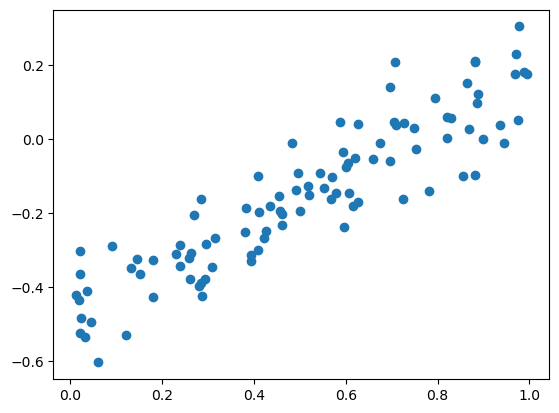

In [1]:
# import numpy as np
# from matplotlib import pyplot as plt
# from linear_regression import LinearRegression

# def pad(X):
#     return np.append(X, np.ones((X.shape[0], 1)), 1)

# w0 = -0.5
# w1 =  0.7

# n = 100
# x = np.random.rand(n, 1)
# y = w1*x + w0 + 0.1*np.random.randn(n, 1)
# plt.scatter(x, y)

# LR = LinearRegression()
# LR.fit_analytic(x, y)
# print(f"ANALYTIC{LR.w=}\n")
# LR.fit_gradient(x, y)
# print(f"GRADIENT{LR.w=}\n")

# plt.plot(x, LR.predict(pad(x)), color = "black")
# labels = plt.gca().set(xlabel = "Feature (x)", ylabel = "Target (y)")

In [2]:
import numpy as np
from matplotlib import pyplot as plt

def pad(X):
    return np.append(X, np.ones((X.shape[0], 1)), 1)

def LR_data(n_train = 100, n_val = 100, p_features = 1, noise = .1, w = None):
    if w is None: 
        w = np.random.rand(p_features + 1) + .2
    
    X_train = np.random.rand(n_train, p_features)
    y_train = pad(X_train)@w + noise*np.random.randn(n_train)

    X_val = np.random.rand(n_val, p_features)
    y_val = pad(X_val)@w + noise*np.random.randn(n_val)
    
    return X_train, y_train, X_val, y_val

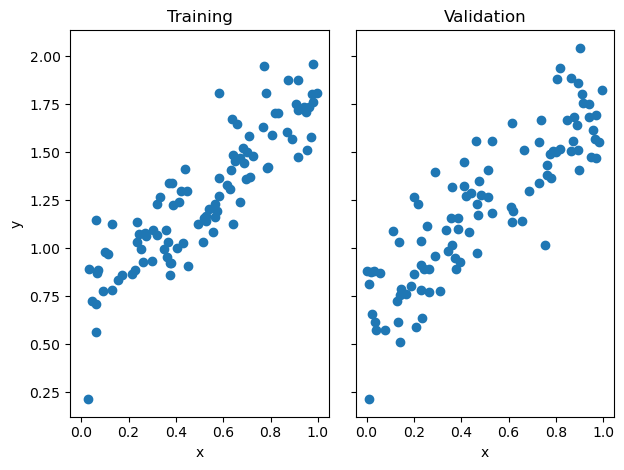

In [11]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

# create some data
X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)

# plot it
fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
axarr[0].scatter(X_train, y_train)
axarr[1].scatter(X_val, y_val)
labs = axarr[0].set(title = "Training", xlabel = "x", ylabel = "y")
labs = axarr[1].set(title = "Validation", xlabel = "x")
plt.tight_layout()

In [12]:
from linear_regression import LinearRegression

LR = LinearRegression()
LR.fit_analytic(X_train, y_train) # I used the analytical formula as my default fit method

print(f"Training score = {LR.score(pad(X_train), y_train).round(4)}")
print(f"Validation score = {LR.score(pad(X_val), y_val).round(4)}")

np.shape(X)=(100, 2)
np.shape(self.w)=(2,)
Training score = 0.7776
np.shape(X)=(100, 2)
np.shape(self.w)=(2,)
Validation score = 0.7429


In [13]:
LR.w

array([1.07774915, 0.71315786])

In [14]:
LR2 = LinearRegression()

LR2.fit_gradient(X_train, y_train, alpha = 0.01, max_iter = 1e2)

(2,)
gradient=array([-22.76048332, -29.40218516])

(2,)
self.w=array([0.11056684, 0.91866088])

np.shape(X)=(100, 2)
np.shape(self.w)=(2,)
np.shape(X)=(100, 2)
np.shape(self.w)=(2,)
(2,)
gradient=array([ 0.27886406, 11.75520626])

(2,)
self.w=array([0.33817167, 1.21268273])

np.shape(X)=(100, 2)
np.shape(self.w)=(2,)
np.shape(X)=(100, 2)
np.shape(self.w)=(2,)
(2,)
gradient=array([-5.88862522, -0.14402614])

(2,)
self.w=array([0.33538303, 1.09513067])

np.shape(X)=(100, 2)
np.shape(self.w)=(2,)
np.shape(X)=(100, 2)
np.shape(self.w)=(2,)
(2,)
gradient=array([-3.78227417,  3.04132399])

(2,)
self.w=array([0.39426929, 1.09657093])

np.shape(X)=(100, 2)
np.shape(self.w)=(2,)
np.shape(X)=(100, 2)
np.shape(self.w)=(2,)
(2,)
gradient=array([-4.04790528,  1.95344767])

(2,)
self.w=array([0.43209203, 1.06615769])

np.shape(X)=(100, 2)
np.shape(self.w)=(2,)
np.shape(X)=(100, 2)
np.shape(self.w)=(2,)
(2,)
gradient=array([-3.66001584,  2.09063932])

(2,)
self.w=array([0.47257108, 1.04662321])

np.s

In [15]:
LR2.w

array([1.07621605, 0.7140011 ])

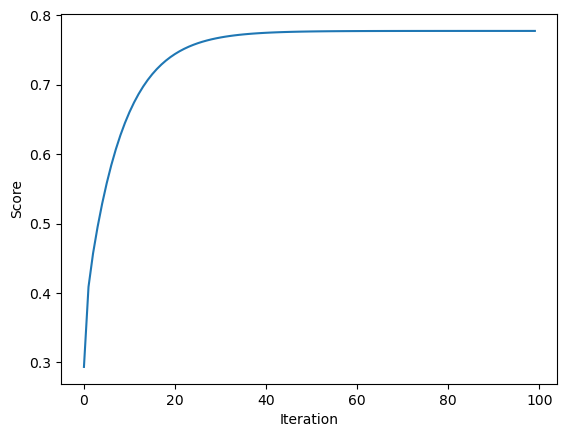

In [16]:
plt.plot(LR2.score_history)
labels = plt.gca().set(xlabel = "Iteration", ylabel = "Score")